# Combining Machine Learned and Empircal Energy Functions

In [1]:
import os
os.environ["CHARMM_HOME"] = "/pchem-data/meuwly/boittier/home/charmm"
os.environ["CHARMM_LIB_DIR"] = "/pchem-data/meuwly/boittier/home/charmm/build/cmake"

# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax

# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys
import e3x
import jax
import numpy as np
import optax
import orbax
from pathlib import Path
import pandas as pd

# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test")
import physnetjax

sys.path.append("/pchem-data/meuwly/boittier/home/dcm-lj-data")
from pycharmm_lingo_scripts import script1, script2, script3, load_dcm


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [2]:
from physnetjax.data.data import prepare_datasets
from physnetjax.training.loss import dipole_calc
from physnetjax.models.model import EF
from physnetjax.training.training import train_model  # from model import dipole_calc
from physnetjax.data.batches import _prepare_batches as prepare_batches #prepare_batches, prepare_datasets

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)

from pathlib import Path

from physnetjax.calc.helper_mlp import get_ase_calc

def parse_non_int(s):
    return "".join([_ for _ in s if _.isalpha()]).lower().capitalize()


def calc_physnet(atomic_numbers, atom_positions, ase_calc_monomer, ase_calc_dimer, dimer_permutations=[(1,2)]):

    ase_monomers_dict = {}
    e_monomers_dict = {}
    for i in range(20):
        start, stop = i*5, i*5 + 5
        Z, R = atomic_numbers, atom_positions
        Z = [_ for i, _ in enumerate(Z) if start <= i < stop  ]
        R = [_ for i, _ in enumerate(R) if start <= i < stop  ]
        ase_atoms_monomer = ase.Atoms(Z, R)
        ase_atoms_monomer.calc = ase_calc_monomer
        ase_monomers_dict[i] = ase_atoms_monomer
        e_monomers_dict[i] = ase_atoms_monomer.get_potential_energy()
        
    monomer_atom_energies = sum( [Eref[z] for z in ase_atoms_monomer.get_atomic_numbers()])
    monomer_atom_energies, ase_atoms_monomer.get_atomic_numbers()
    
    ase_dimers_dict = {}
    e_dimers_dict = {}
    
    for perm in dimer_permutations:
        a,b = perm
        monomer1 = ase_monomers_dict[a]
        monomer2 = ase_monomers_dict[b]
        ase_atoms_dimer = monomer1 + monomer2
        ase_atoms_dimer.calc = ase_calc_dimer
        ase_dimers_dict[i] = ase_atoms_dimer
        e_dimers_dict[perm] = ase_atoms_dimer.get_potential_energy()
    
    eint_dimers_dict = {}
    
    for perm in dimer_permutations:
        a,b = perm
    
        tot_e_dimer = e_dimers_dict[perm] 
        monomer1_tot_e = e_monomers_dict[a]
        monomer2_tot_e = e_monomers_dict[b]
        eint_dimers_dict[perm] = tot_e_dimer - (monomer1_tot_e + monomer2_tot_e)
    
    sum_of_monomers = float(sum(list(e_monomers_dict.values())))
    sum_of_dimers = float(sum(list(e_dimers_dict.values())))
    
    dimer_intE = float(sum(list(eint_dimers_dict.values())))
    sum_of_monomers_total_e = monomer_atom_energies*20 + sum_of_monomers / 627.509
    return {"dimer_intE": dimer_intE, "sum_of_monomers_total_e": sum_of_monomers_total_e}

2025-02-19 11:58:36.943893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739962716.966786   66752 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739962716.974226   66752 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 11:58:41.496871: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.8.61. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# set reference atomic energies

In [3]:
Eref = np.zeros([20], dtype=float)
Eref[1] = -0.498232909223
Eref[6] = -37.731440432799
Eref[8] = -74.878159582108
Eref[17] = -459.549260062932

# Fitting the ML model

In [4]:
NATOMS = 10

model = EF(
    # attributes
    features=128,
    max_degree=0,
    num_iterations=5,
    num_basis_functions=64,
    cutoff=10.0,
    max_atomic_number=18,
    charges=True,
    natoms=NATOMS,
    total_charge=0,
    n_res=3,
    zbl=False,
    debug=False,
)

In [5]:
files = [
    Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz"),

]

In [6]:
restart = None
if RESTART_ML:
    restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1"


if TRAIN_ML:
    train_data, valid_data = prepare_datasets(
        data_key,
        16800,
         4199,
        files,
        clip_esp=False,
        natoms=NATOMS,
        clean=False,
        subtract_atom_energies=False,
        verbose=True,
    )
    
    ntest = len(valid_data["E"]) // 2
    test_data = {k: v[ntest:] for k, v in valid_data.items()}
    valid_data = {k: v[:ntest] for k, v in valid_data.items()}

    DEFAULT_DATA_KEYS = ["Z", "R", "D", "E", "F", "N"]
    batch_size = 10
    
    test_batches = prepare_batches(data_key, test_data, batch_size,
                                  num_atoms=NATOMS, 
                                  data_keys=DEFAULT_DATA_KEYS)
    
    train_batches = prepare_batches(data_key, train_data, batch_size,
                                  num_atoms=NATOMS, 
                                  data_keys=DEFAULT_DATA_KEYS)
    
    valid_batches = prepare_batches(data_key, valid_data, batch_size,
                                  num_atoms=NATOMS, 
                                  data_keys=DEFAULT_DATA_KEYS)
    
    params = train_model(
        train_key,
        model,
        train_data,
        valid_data,
        num_epochs=int(1e6),
        learning_rate=0.0001,
        energy_weight=1,
        dipole_weight=1,
        charges_weight=1,
        forces_weight=1,
        schedule_fn="constant",
        optimizer="amsgrad",
        batch_size=batch_size,
        num_atoms=NATOMS,
        data_keys=DEFAULT_DATA_KEYS,
        restart=restart,
        name="dichloromethane",
        print_freq=1,
        objective="valid_loss",
        best=1e6,
        batch_method="default",
    )

if ANALYSE_ML:
    output = plot_stats(test_batches, model, params, _set="Test", 
                   do_kde=True, batch_size=batch_size)

NameError: name 'RESTART_ML' is not defined

# Analysing the fit of the model

In [ ]:
_ = plt.hist(output["Es"] - output["predEs"], bins=100)
plt.scatter(output["Es"] , output["predEs"], alpha=0.1)
plt.xlim(-800, -750)
plt.ylim(-800, -750)
plt.plot([-800, -750], [-800, -750])
plt.show()
plt.scatter(output["Es"] , output["predEs"], alpha=0.1)
plt.xlim(-390, -375)
plt.ylim(-390, -375)
plt.plot([-390, -375], [-390, -375])

In [ ]:
import pycharmm

import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm



import ase
from ase.io import read as read_ase
from ase import visualize
from ase.visualize import view

ev2kcalmol = 1/(ase.units.kcal / ase.units.mol)


def set_pycharmm_xyz(atom_positions):
    xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
    coor.set_positions(xyz)

def capture_neighbour_list():
    # Print something
    distance_command = """
    open unit 1 write form name total.dmat
    
    COOR DMAT SINGLE UNIT 1 SELE ALL END SELE ALL END
    
    close unit 1"""
    _ = pycharmm.lingo.charmm_script(distance_command)
    
    with open("total.dmat") as f:
        output_dmat = f.read()
    
    atom_number_type_dict = {}
    atom_number_resid_dict = {}
    
    pair_distance_dict = {}
    pair_resid_dict = {}
    
    for _ in output_dmat.split("\n"):
        if _.startswith("*** "):
            _, n, resid, resname, at, _ = _.split()
        
            n = int(n.split("=")[0]) - 1
            atom_number_type_dict[n] = at
            atom_number_resid_dict[n] = int(resid) - 1
            
    for _ in output_dmat.split("\n"):        
        if _.startswith("  "):
            a, b, dist = _.split()
            a = int(a) - 1
            b = int(b) - 1
            dist = float(dist)
            if (atom_number_resid_dict[a] < atom_number_resid_dict[b]):
                pair_distance_dict[(a, b)] = dist
                pair_resid_dict[(a, b)] = (atom_number_resid_dict[a], atom_number_resid_dict[b])

    return     {"atom_number_type_dict" : atom_number_type_dict,
    "atom_number_resid_dict" : atom_number_resid_dict,
    "pair_distance_dict" : pair_distance_dict,
    "pair_resid_dict" : pair_resid_dict,}

def get_forces_pycharmm():
    positions = coor.get_positions()
    force_command = """coor force sele all end"""
    _ = pycharmm.lingo.charmm_script(force_command)
    forces = coor.get_positions()
    coor.set_positions(positions)
    return forces

def view_atoms(atoms):
    return view(atoms, viewer="x3d")


from itertools import combinations

def dimer_permutations(n_mol):
    dimer_permutations = list(combinations(range(n_mol), 2))
    return dimer_permutations

def calc_pycharmm_dimers(n_mol = 20):
    
    RANGE = len(dimer_permutations(n_mol))
    
    ele_energies = np.zeros(RANGE)
    evdw_energies = np.zeros(RANGE)
    
    for i, (a,b) in enumerate(dimer_permutations(20)):
        a += 1
        b += 1
        print(a, b)
        block = f"""BLOCK 2
        CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
          CALL 2 SELE (RESID {a} .OR. RESID {b}) END
          COEFF 1 1 0.0
          COEFF 2 2 1.0
          COEFF 1 2 0.0
        END
        """
        _ = pycharmm.lingo.charmm_script(block)
        # print(_)
        energy.show()
        # energy.show()
        
        evdw = energy.get_vdw()
        evdw_energies[i] = evdw
        e = energy.get_elec()
        ele_energies[i] = e

    return {"ele_energies": ele_energies, "evdw_energies": evdw_energies}

def reset_block():
        block = f"""BLOCK 1
        CALL 1 SELE ALL END
          COEFF 1 1 1.0
        END
        """
        _ = pycharmm.lingo.charmm_script(block)

reset_block()

In [ ]:
import MDAnalysis as mda

def load_pdb_data(pdb_file):
    loaded_pdb = mda.coordinates.PDB.PDBReader(pdb_file)
    loaded_pdb = mda.topology.PDBParser.PDBParser(pdb_file)
    
    u = mda.Universe(pdb_file)
    atom_names = [s for s in list(u.atoms.names)]
    atom_positions = list(u.atoms.positions)
    atomic_numbers = np.array([ase.data.atomic_numbers[parse_non_int(s)] for s in atom_names])
    mda_resids = [s for s in list(u.atoms.resids)]
    mda_res_at_dict = {(a-1,b): i for i, (a,b) in enumerate(zip(mda_resids, atom_names))}
    charmm_res_at_dict = {(a,b): i for i, (a,b) in enumerate(zip(resids, atypes))}
    an_charmm_res_at_dict = {v: k for k,v in charmm_res_at_dict.items()}
    an_mda_res_at_dict = {v: k for k,v in mda_res_at_dict.items()}
    atom_positions = np.array(atom_positions)
    reorder = np.array([charmm_res_at_dict[an_mda_res_at_dict[i]] for i in range(len(atom_positions))])
    atom_positions = atom_positions[reorder]
    atomic_numbers = atomic_numbers[reorder]

   
    return {"atom_names" : atom_names,
    "atom_positions" : atom_positions,
    "atomic_numbers" : atomic_numbers,
    "mda_resids" : mda_resids,
    "mda_res_at_dict" : mda_res_at_dict,
    "charmm_res_at_dict" : charmm_res_at_dict,
    "an_charmm_res_at_dict" : an_charmm_res_at_dict,
    "an_mda_res_at_dict" : an_mda_res_at_dict,
    "atom_positions" : atom_positions,
    "reorder" : reorder,
    "atom_positions" : atom_positions,
    "atomic_numbers" : atomic_numbers,
    }

def get_data_mda(fn):
    pdb_file = data_path / "dcmk" / fn
    pdb_data_mda = load_pdb_data(pdb_file)
    return pdb_data_mda

In [ ]:
pycharmm.lingo.charmm_script(script1)
pycharmm.lingo.charmm_script(script2)

pycharmm.lingo.charmm_script(load_dcm)

energy.show()
vdw = energy.get_vdw()
elec = energy.get_elec()

# Load the restarts

In [34]:
from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-af722a47-a3a3-4f31-987f-c6a9ab2fb555"
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d8bc5d79-f65e-451e-8169-bf6da5170b54"
restart_path = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1"

restart = get_last(restart_path)
params, dimer_model = get_params_model(restart)
dimer_model.natoms = 10
print(dimer_model)



/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 18
    charges = True
    natoms = 10
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)


In [35]:
restart = get_last(restart_path)
params, monomer_model = get_params_model(restart)
monomer_model.natoms = 5
print(monomer_model)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 18
    charges = True
    natoms = 5
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)


In [36]:
Z, R = atomic_numbers, atom_positions
Z = [_ for i, _ in enumerate(Z) if i < 5  ]
R = [_ for i, _ in enumerate(R) if i < 5  ]
ase_atoms_monomer = ase.Atoms(Z, R)
# view_atoms(ase_atoms_monomer)

In [37]:
# TODO: add default keys to the conversion dict
ase_calc_monomer = get_ase_calc(params, monomer_model, ase_atoms_monomer, conversion={"energy": ev2kcalmol, "dipole": 1, "forces": ev2kcalmol})
ase_atoms_monomer.calc = ase_calc_monomer
float(ase_atoms_monomer.get_potential_energy())

-385.333251953125

In [38]:
Z, R = atomic_numbers, atom_positions
Z = [_ for i, _ in enumerate(Z) if i < 10  ]
R = [_ for i, _ in enumerate(R) if i < 10  ]
ase_atoms_dimer = ase.Atoms(Z, R)
ase_calc_dimer = get_ase_calc(params, dimer_model, ase_atoms_dimer, conversion={"energy": ev2kcalmol, "dipole": 1, "forces": ev2kcalmol})
# view_atoms(ase_atoms_dimer)

# Charmm PSF data

In [217]:
atypes = psf.get_atype()
atc = pycharmm.param.get_atc()
residues = psf.get_res()
psf.get_natom()

# TODO: this assumes a pure system, need to update
atoms_per_res = int(len(atypes) / len(residues))
n_res = len(residues)
resids = np.array([[i]*atoms_per_res for i in range(n_res)]).flatten()


# Data 

In [40]:
data_path = Path("/pchem-data/meuwly/boittier/home/dcm-lj-data")
df = pd.read_csv(data_path / "formation_energies_kcal_mol.csv", sep="\t")
df

,Cluster,Cluster Energy,Monomer Sum,Formation Energy (Hartree),Formation Energy (kcal/mol)
0,100_LIG_1,-19168.893238,-19168.826734,-0.066504,-41.731854
1,100_LIG_10,-19168.874696,-19168.806251,-0.068444,-42.949509
2,100_LIG_100,-19168.892131,-19168.828790,-0.063341,-39.747275
3,100_LIG_11,-19168.872941,-19168.815802,-0.057139,-35.855129
4,100_LIG_12,-19168.871378,-19168.821103,-0.050275,-31.547863
...,...,...,...,...,...
95,100_LIG_95,-19168.893409,-19168.829056,-0.064353,-40.382115
96,100_LIG_96,-19168.879736,-19168.820661,-0.059075,-37.069863
97,100_LIG_97,-19168.887691,-19168.826441,-0.061250,-38.435091
98,100_LIG_98,-19168.893152,-19168.828568,-0.064584,-40.527012


In [41]:
fn = "100_lig_1_modified.pdb"
pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = pdb_data_mda["atomic_numbers"], pdb_data_mda["atom_positions"]
set_pycharmm_xyz(atom_positions)
energy.show()


 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    RDIElec  SWITch   VATOm    VSWItch 
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  =  8.000 CTEXNB =999.000 CTONNB =  6.500 CTOFNB =  7.500
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are     1989 atom  pairs and      200 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.

      ***** LEVEL  1 WARNING FROM <GTNBCT> *****
      ***** CUTNB and CTOFNB are too close for efficient heuristic update.
      ******************************************
      BOMLEV (  0) IS NOT REACHED. WRNLEV IS  5

 Generating nonbond list with Exclusion mode = 5
 == PRIMARY == SPACE FOR     4901 ATOM PAIRS AND        0 GROUP PAIRS

 General atom nonbond list generation found:
     1989 ATOM PAIRS WERE FOUND FOR ATOM LIST
      139 GROUP PAIRS REQUIRED ATOM SEARCHES

ENER ENR:  Eval#     ENERgy      Delta-E         GRMS
ENER INTERN:          BONDs       A

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [63]:
ase_atoms = ase.Atoms(atomic_numbers, atom_positions)

# ase_atoms = ase.Atoms(atomic_numbers, forces.to_numpy())

view_atoms(ase_atoms)

# Load the pdb files

In [219]:
fn = "100_lig_1_modified.pdb"


In [220]:
pdb_data_mda = get_data_mda(fn)

In [221]:
# pdb_data_mda

In [222]:
data_path = Path("/pchem-data/meuwly/boittier/home/dcm-lj-data")
df = pd.read_csv(data_path / "formation_energies_kcal_mol.csv", sep="\t")
df["key"] = df["Cluster"].apply(lambda x: "_".join(x.split("_")[:3]).upper() )
df

,Cluster,Cluster Energy,Monomer Sum,Formation Energy (Hartree),Formation Energy (kcal/mol),key
0,100_LIG_1,-19168.893238,-19168.826734,-0.066504,-41.731854,100_LIG_1
1,100_LIG_10,-19168.874696,-19168.806251,-0.068444,-42.949509,100_LIG_10
2,100_LIG_100,-19168.892131,-19168.828790,-0.063341,-39.747275,100_LIG_100
3,100_LIG_11,-19168.872941,-19168.815802,-0.057139,-35.855129,100_LIG_11
4,100_LIG_12,-19168.871378,-19168.821103,-0.050275,-31.547863,100_LIG_12
...,...,...,...,...,...,...
95,100_LIG_95,-19168.893409,-19168.829056,-0.064353,-40.382115,100_LIG_95
96,100_LIG_96,-19168.879736,-19168.820661,-0.059075,-37.069863,100_LIG_96
97,100_LIG_97,-19168.887691,-19168.826441,-0.061250,-38.435091,100_LIG_97
98,100_LIG_98,-19168.893152,-19168.828568,-0.064584,-40.527012,100_LIG_98


# Process the data

In [1263]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

per_monomer = pd.read_pickle("per_monomer.pkl")
per_cluster = pd.read_pickle("per_cluster.pkl")
per_dimer = pd.read_pickle("per_dimer.pkl")
per_neighbour = pd.read_pickle("per_neighbour.pkl")

In [1264]:
per_monomer[0].keys()

dict_keys(['e_monomers', 'f_monomers', 'r_monomers', 'z_monomers'])

In [1266]:
per_monomer[0]['f_monomers']

{0: Array[5, 3] n=15 x∈[-30.855, 32.911] μ=-6.358e-08 σ=16.375 gpu:0,
 1: Array[5, 3] n=15 x∈[-37.388, 24.671] μ=-2.543e-07 σ=17.418 gpu:0,
 2: Array[5, 3] n=15 x∈[-19.210, 23.896] μ=-1.589e-08 σ=11.007 gpu:0,
 3: Array[5, 3] n=15 x∈[-31.930, 51.469] μ=-6.358e-08 σ=20.622 gpu:0,
 4: Array[5, 3] n=15 x∈[-24.083, 18.615] μ=4.768e-08 σ=10.896 gpu:0,
 5: Array[5, 3] n=15 x∈[-30.994, 29.075] μ=6.676e-07 σ=15.566 gpu:0,
 6: Array[5, 3] n=15 x∈[-21.376, 35.723] μ=6.358e-08 σ=13.306 gpu:0,
 7: Array[5, 3] n=15 x∈[-34.371, 12.482] μ=-1.272e-07 σ=13.706 gpu:0,
 8: Array[5, 3] n=15 x∈[-35.536, 19.581] μ=1.272e-07 σ=15.981 gpu:0,
 9: Array[5, 3] n=15 x∈[-28.037, 29.970] μ=5.086e-07 σ=13.801 gpu:0,
 10: Array[5, 3] n=15 x∈[-48.782, 36.090] μ=-4.768e-08 σ=19.937 gpu:0,
 11: Array[5, 3] n=15 x∈[-31.142, 36.709] μ=1.272e-07 σ=21.013 gpu:0,
 12: Array[5, 3] n=15 x∈[-22.042, 39.027] μ=-6.358e-07 σ=17.338 gpu:0,
 13: Array[5, 3] n=15 x∈[-20.717, 12.420] μ=6.358e-08 σ=8.286 gpu:0,
 14: Array[5, 3] n=15 x∈

In [1270]:
np.load(Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz"))["F"][0]

array([[ 0.94915263, -1.3794278 ,  2.23090679],
       [ 0.43535825,  0.12158542, -0.52125572],
       [-0.43584573,  0.95196747, -0.46369283],
       [ 0.0232402 ,  0.71289857, -0.52120996],
       [-0.97190586, -0.40702314, -0.72474776],
       [-0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ]])

In [1267]:
# per_dimer[0]["f_dimers_dict"]

In [1257]:
per_monomer_df = pd.DataFrame([{k: float(v) for k,v in per_monomer[i]["e_monomers"].items()} for i in range(len(per_monomer))])
per_cluster_df = pd.DataFrame(per_cluster)
df = df.merge(per_cluster_df, on="key")
df

,Cluster,Cluster Energy,Monomer Sum,Formation Energy (Hartree),Formation Energy (kcal/mol),key,sum_ele_x,sum_vdw_x,filename_x,dimer_intE_x,sum_of_monomers_x,monomer_atom_energies_x,sum_ele_y,sum_vdw_y,filename_y,dimer_intE_y,sum_of_monomers_y,monomer_atom_energies_y
0,100_LIG_1,-19168.893238,-19168.826734,-0.066504,-41.731854,100_LIG_1,-1.839392,-46.566648,100_lig_1_modified.pdb,-33.272949,-7717.962402,0.0,-1.839392,-46.566648,100_lig_1_modified.pdb,-33.205139,-7717.966309,0.0
1,100_LIG_10,-19168.874696,-19168.806251,-0.068444,-42.949509,100_LIG_10,-4.353729,-41.532364,100_lig_10_modified.pdb,-38.622192,-7704.999023,0.0,-4.353729,-41.532364,100_lig_10_modified.pdb,-38.611755,-7705.000000,0.0
2,100_LIG_100,-19168.892131,-19168.828790,-0.063341,-39.747275,100_LIG_100,-5.118395,-39.503451,100_lig_100_modified.pdb,-33.942688,-7719.346680,0.0,-5.118395,-39.503451,100_lig_100_modified.pdb,-33.912537,-7719.347168,0.0
3,100_LIG_11,-19168.872941,-19168.815802,-0.057139,-35.855129,100_LIG_11,-1.628175,-37.788496,100_lig_11_modified.pdb,-32.860962,-7711.097168,0.0,-1.628175,-37.788496,100_lig_11_modified.pdb,-32.837463,-7711.098633,0.0
4,100_LIG_12,-19168.871378,-19168.821103,-0.050275,-31.547863,100_LIG_12,-2.594450,-35.924987,100_lig_12_modified.pdb,-30.907043,-7714.451172,0.0,-2.594450,-35.924987,100_lig_12_modified.pdb,-30.886414,-7714.453613,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,100_LIG_95,-19168.893409,-19168.829056,-0.064353,-40.382115,100_LIG_95,-3.622256,-44.843449,100_lig_95_modified.pdb,-30.003418,-7719.345703,0.0,-3.622256,-44.843449,100_lig_95_modified.pdb,-29.970764,-7719.347168,0.0
96,100_LIG_96,-19168.879736,-19168.820661,-0.059075,-37.069863,100_LIG_96,-1.211806,-43.061908,100_lig_96_modified.pdb,-27.193176,-7714.094727,0.0,-1.211806,-43.061908,100_lig_96_modified.pdb,-27.217102,-7714.093750,0.0
97,100_LIG_97,-19168.887691,-19168.826441,-0.061250,-38.435091,100_LIG_97,-2.832370,-43.381121,100_lig_97_modified.pdb,-29.362183,-7717.747070,0.0,-2.832370,-43.381121,100_lig_97_modified.pdb,-29.354492,-7717.747559,0.0
98,100_LIG_98,-19168.893152,-19168.828568,-0.064584,-40.527012,100_LIG_98,-5.438638,-40.175994,100_lig_98_modified.pdb,-35.002197,-7719.204590,0.0,-5.438638,-40.175994,100_lig_98_modified.pdb,-35.030701,-7719.202637,0.0


In [392]:
per_dimer_ele_energies_df = pd.DataFrame([per_dimer[i]["ele_energies"] for i in range(len(per_dimer))])
per_dimer_e_dimers_df = pd.DataFrame([{
    k: float(v) for k,v in per_dimer[i]["e_dimers_dict"].items()
} for i in range(len(per_dimer))])
per_dimer_evdw_energies_df = pd.DataFrame([per_dimer[i]["evdw_energies"] for i in range(len(per_dimer))])
pair_distance_df = pd.DataFrame([per_neighbour[i]["pair_distance_dict"] for i in range(100)])
pair_resid_df = pd.DataFrame([per_neighbour[i]["pair_resid_dict"] for i in range(100)])
per_dimer_monomersum_e_dimers_df = pd.DataFrame([{
    k: float(v) for k,v in per_dimer[i]["emonomers_dimers_dict"].items()
} for i in range(len(per_dimer))])

In [263]:
cluster_pair_distance_dict = pair_distance_df.T.to_dict()


In [264]:
carbon_atoms_res_at_dict = {k:v for k,v in pdb_data_mda["charmm_res_at_dict"].items() if k[1] == "C"}
carbon_atoms_res_at_dict = {k[0]:v for k,v in pdb_data_mda["charmm_res_at_dict"].items() if k[1] == "C"}

carbon_atoms_ids = [v for k,v in pdb_data_mda["charmm_res_at_dict"].items() if k[1] == "C"]
carbon_res_keys = [k for k,v in pdb_data_mda["charmm_res_at_dict"].items() if k[1] == "C"]


In [266]:
pair_keys = list(per_dimer_eint_dimers_dict.columns)
c_pairs_res_an_dict = { k: (carbon_atoms_res_at_dict[k[0]], 
                            carbon_atoms_res_at_dict[k[1]] ) for k in pair_keys}

In [280]:
cluster_cc_pair_dist_dict = {i: {k: cluster_pair_distance_dict[i][v] for k,v in c_pairs_res_an_dict.items()} for i in range(100)}

In [297]:
pair_cc_distances_per_dimer_np = np.array([[cluster_cc_pair_dist_dict[i][pk] for pk in pair_keys] for i in range(100)])

In [304]:
per_dimer_ele_energies_np = per_dimer_ele_energies_df.to_numpy()


(100, 190)

In [305]:
per_dimer_evdw_energies_np = per_dimer_evdw_energies_df.to_numpy()


(100, 190)

In [858]:
per_dimer_charmm_energies_np =  per_dimer_evdw_energies_np - per_dimer_ele_energies_np


(100, 190)

In [864]:
per_dimer_ml_energies_np = per_dimer_e_dimers_df.to_numpy() - per_dimer_monomersum_e_dimers_df.to_numpy()

In [867]:
epsilon = 10**(-6)
from e3x.nn import smooth_switch, smooth_cutoff

def combine_with_sigmoid(r, mm_energy, ml_energy, 
                         dif = 10**(-6), 
                         MM_CUTON = 8.0, 
                         MM_CUTOFF = 14, BUFFER = 0.1,
                        debug=False):
    
    ML_CUTOFF = MM_CUTON - dif
    charmm_on_scale = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
    charmm_off_scale = smooth_cutoff(r - MM_CUTON, cutoff=MM_CUTOFF - MM_CUTON)
    # remove any sigularities
    charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)
    
    ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    ml_contrib = ml_scale * ml_energy

    mm_contrib = charmm_on_scale * mm_energy 
    mm_contrib =  mm_contrib * charmm_off_scale 

    
    return mm_contrib, ml_contrib, charmm_off_scale, charmm_on_scale, ml_scale



In [868]:
mm_contrib, ml_contrib, charmm_off_scale, charmm_on_scale, ml_scale = combine_with_sigmoid(
    pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np)
mm_flat = mm_contrib.flatten()
ml_flat = ml_contrib.flatten()
r_flat = pair_cc_distances_per_dimer_np.flatten()
charmm_on_scale_flat =  charmm_on_scale.flatten()
charmm_off_scale_flat = charmm_off_scale.flatten()
ml_scale_flat = ml_scale.flatten()
mm_E = per_dimer_charmm_energies_np.flatten()
ml_E = per_dimer_ml_energies_np.flatten()
qm_E = df["Formation Energy (kcal/mol)"].to_numpy()

In [869]:
import jax.numpy as jnp
jnp.array(per_dimer_charmm_energies_np).reshape(100, 190).sum(axis=1)

Array[100] x∈[-48.732, -30.423] μ=-39.734 σ=4.330 gpu:0

In [870]:
jnp.array(per_dimer_ml_energies_np).reshape(100, 190).sum(axis=1)

Array[100] x∈[-50.367, -23.036] μ=-34.103 σ=6.090 gpu:0

In [871]:
jnp.array(qm_E)

Array[100] x∈[-53.654, -26.118] μ=-40.448 σ=5.735 gpu:0

In [1147]:
colors = {
    'blue':   [55,  126, 184],  #377eb8 
    'orange': [255, 127, 0],    #ff7f00
    'green':  [77,  175, 74],   #4daf4a
    'pink':   [247, 129, 191],  #f781bf
    'brown':  [166, 86,  40],   #a65628
    'purple': [152, 78,  163],  #984ea3
    'gray':   [153, 153, 153],  #999999
    'red':    [228, 26,  28],   #e41a1c
    'yellow': [222, 222, 0]     #dede00
}  
from matplotlib.colors import to_hex as to_hex
# matplotlib.colors.to_hex
INTECOLOR =  "#984ea3" #to_hex(tuple([152, 78,  163]))
MMCOLOR = "#e41a1c" #to_hex(tuple([228, 26,  28]))
MLCOLOR = "#377eb8" #to_hex(tuple([153, 153, 153]))
SCALECOLOR = "#999999" #to_hex(tuple([55,  126, 184]))
plt.style.use('fast')
# plt.style.use('tableau-colorblind10')

In [1258]:
def plot(pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np,
    dif = 10**(-6), 
    MM_CUTON = 8.0, MM_CUTOFF = 14, 
    BUFFER = 0.1,
    MM_E_scale = 1,
    ML_E_scale = 1,
    E_SHIFT = 0,
    ALPHA=0.01,
        plot=False,
        ):
    """
    """
    r = pair_cc_distances_per_dimer_np

    _ = combine_with_sigmoid(
        pair_cc_distances_per_dimer_np,
        per_dimer_charmm_energies_np, 
        per_dimer_ml_energies_np, 
        dif=dif,MM_CUTON=MM_CUTON, MM_CUTOFF=MM_CUTOFF, BUFFER=BUFFER
    )
    mm_contrib, ml_contrib, charmm_off_scale, charmm_on_scale, ml_scale = _

    # SCALE THE MM CONTRIBUTION HERE
    mm_flat = MM_E_scale * mm_contrib.flatten()
    ml_flat = ML_E_scale * ml_contrib.flatten()
    
    r_flat = pair_cc_distances_per_dimer_np.flatten()
    
    charmm_on_scale_flat =  charmm_on_scale.flatten()
    charmm_off_scale_flat = charmm_off_scale.flatten()
    ml_scale_flat = ml_scale.flatten()
    mm_E = per_dimer_charmm_energies_np.flatten()
    ml_E = per_dimer_ml_energies_np.flatten()
    qm_E = df["Formation Energy (kcal/mol)"].to_numpy()
    
    mm_reshaped = (mm_flat).reshape(100, 190).sum(axis=1)
    ml_reshaped = (ml_flat).reshape(100, 190).sum(axis=1)
    combined_potential = mm_reshaped + ml_reshaped + E_SHIFT

    error = qm_E - combined_potential
    mae = np.mean(abs((error)))
    rmse = (np.mean(((error)**2))**0.5)

    if plot:

        MMC, MLC, MMMLC, IEC, IEMSC = 0, 1, 2, 3, 4
        CRY, CXY, CS = 1, 0, 2
        
        ML_CUTOFF = MM_CUTON - dif
        r_flat_sorted, _ml_scale_flat = np.array(
            sorted(zip(r_flat, ml_scale_flat), key=lambda x: x[0])).T
        r_flat_sorted, _charmm_off_scale_flat = np.array(
            sorted(zip(r_flat, charmm_off_scale_flat), key=lambda x: x[0])).T
        r_flat_sorted, _charmm_on_scale_flat = np.array(
            sorted(zip(r_flat, charmm_on_scale_flat), key=lambda x: x[0])).T
        ml_scale_flat = _ml_scale_flat
        charmm_off_scale_flat = _charmm_off_scale_flat
        charmm_on_scale_flat = _charmm_on_scale_flat

        fig, axes = plt.subplots(3,5, figsize=(16,16), height_ratios=[1, 1, 0.5])
        
        axes[0,MMC].set_title(f"MM ($\lambda =$ {MM_E_scale:.1f})")
        axes[CRY,MMC].scatter(r, mm_flat, label="with switch/cutoff", marker="x", color=MMCOLOR, alpha=ALPHA*5,)
        axes[CRY,MMC].scatter(r, mm_E, label="original", alpha=ALPHA, marker="o", color=MMCOLOR)
        axes[CXY,MMC].scatter(mm_E, mm_flat, label="original", alpha=ALPHA, marker="o", color=MMCOLOR)
        
        axes[0,MLC].set_title(f"ML ($\lambda =$ {ML_E_scale:.1f})")
        axes[CRY,0].set_ylabel("Energy (kcal/mol)")
        axes[CXY,0].set_ylabel("Energy (kcal/mol)")
        axes[CXY,MMC].set_xlabel("Energy (kcal/mol)")
        axes[CXY,MLC].set_xlabel("Energy (kcal/mol)")
        axes[CXY,MMMLC].set_xlabel("Energy (kcal/mol)")
        axes[CXY,IEC].set_xlabel("Error (kcal/mol)")
        axes[CXY,IEMSC].set_xlabel("Error (kcal/mol)")
        
        axes[CRY,MLC].scatter(r, ml_flat, label="with switch/cutoff", alpha=ALPHA*5,  marker='x')
        axes[CRY,MLC].scatter(r, ml_E, alpha=ALPHA, color=MLCOLOR, marker="o")
        axes[CXY,MLC].scatter(mm_E, ml_flat, alpha=ALPHA, color=MLCOLOR, marker="o")

        
        axes[CS,MMC].plot(r_flat_sorted, charmm_off_scale_flat, label="MM cut-off", color=SCALECOLOR, linestyle="--") 
        axes[CS,MMC].plot(r_flat_sorted, charmm_on_scale_flat, label="MM switch", color=SCALECOLOR, linestyle="dotted") 
        axes[CS,MMC].plot(r_flat_sorted, charmm_off_scale_flat*charmm_on_scale_flat, 
                       label="MM combined", marker='.', linestyle="solid", color=SCALECOLOR)
        axes[CS,MMC].set_ylabel("Scaling factor")
        axes[CS,MMC].fill_between(r_flat_sorted, charmm_off_scale_flat*charmm_on_scale_flat, 
                       color=MMCOLOR, alpha=0.5)
        # axes[1,0].fill_between(r_flat_sorted, charmm_off_scale_flat, 
        #                color=SCALECOLOR, alpha=0.5)
        axes[CS,MLC].plot(r_flat_sorted, ml_scale_flat, label="ML switch",  color=SCALECOLOR, linestyle="dashdot")
        axes[CS,MLC].fill_between(r_flat_sorted, ml_scale_flat, 
                       color=MLCOLOR, alpha=0.5)
        
        axes[0,MMMLC].set_title("ML + MM")
        axes[CRY,MMMLC].scatter(r, ml_flat + mm_flat, label="original", color = INTECOLOR, alpha=ALPHA)
        axes[CXY,MMMLC].scatter( ml_E + mm_E, ml_flat + mm_flat, label="original", color = INTECOLOR, alpha=ALPHA)
        axes[CS,MMMLC].plot(r_flat_sorted, ml_scale_flat,  color=MLCOLOR, linestyle="dashdot")

        axes[CS,MMMLC].plot(r_flat_sorted, charmm_off_scale_flat*charmm_on_scale_flat, 
                       label="MM combined", marker='.', linestyle="solid", color=SCALECOLOR,)
        
        axes[CS,MMMLC].fill_between(r_flat_sorted, charmm_off_scale_flat*charmm_on_scale_flat, 
                       color=MMCOLOR, alpha=0.5)
        axes[CS,MMMLC].fill_between(r_flat_sorted, ml_scale_flat, 
                       color=MLCOLOR, alpha=0.5)
        
        for col in [MMC, MLC, MMMLC]:
            for row in [CRY, CS]:
                if col < 3:
                    _ = axes[row, col]
                    _.axvline(MM_CUTON, c="k", linestyle="--", alpha=0.5)
                    _.axvline(MM_CUTOFF, c="k", linestyle="--", alpha=0.5)
                    _.axvline(ML_CUTOFF, c="k", linestyle="--", alpha=0.5)
                    _.axhline(0, color="k", linestyle="--", alpha=0.1)

                    if row == CS:
                        _.text(np.mean([MM_CUTON, MM_CUTOFF]), 1.075, 
                               f"({MM_CUTON:.2f} $\\rm \AA$) ({MM_CUTOFF:.2f} $\\rm \AA$)",
                              ha="center")
        
        for i in range(4):
            if i < 3:
                axes[CRY, i].set_ylim(-.5,.5)
                axes[2, i].set_xlabel(r"$r$ ($\rm \AA$)")

        axes[0, IEC].scatter(qm_E, combined_potential, alpha=0.4, color=INTECOLOR)
        axes[0, IEC].set_xlim(-55, -22)
        axes[0, IEC].set_ylim(-55, -22)
        for c in [MMC, MLC, MMMLC, IEC, IEMSC]:
            for r in [CXY, CS, CRY]:
                if r == CXY or (r in [IEC, IEMSC] and (c == CXY or r == CS)): 
                    axes[r, c].plot([0,1],[0,1], transform=axes[r, c].transAxes, color="k", alpha=0.5)
        axes[0, IEC].set_title(f"Fitting Error")
        
        axes[1, IEC].set_title(f"MAE,RMSE = {float(mae):.1f},{float(rmse):.1f}", fontsize=12)
        axes[1, IEC].hist(error, color=INTECOLOR)
        axes[1, IEC].set_xlabel("Error (kcal/mol)")
       
        error = (qm_E - qm_E.mean()) - (combined_potential - combined_potential.mean()) 
        mae = np.mean(abs((error)))
        rmse = (np.mean(((error)**2))**0.5)
    
        axes[0, IEMSC].scatter((qm_E - qm_E.mean()), (combined_potential - combined_potential.mean()), 
                           alpha=0.4, color=INTECOLOR)
        # axes[0, IEMSC].plot([0,1],[0,1], transform=axes[0, 4].transAxes, color="k", alpha=0.5)
        axes[0, IEMSC].set_title(f"(Mean shifted)")
    
        axes[1, IEMSC].set_title(f"MAE,RMSE = {float(mae):.1f},{float(rmse):.1f}", fontsize=12)
        axes[1, IEMSC].hist(error, color=INTECOLOR)
        axes[1, IEMSC].set_xlabel("Error (kcal/mol)")
        # axes[1, 4].set_ylabel("Count")

    return rmse

<>:64: SyntaxWarning: invalid escape sequence '\l'
<>:69: SyntaxWarning: invalid escape sequence '\l'
<>:120: SyntaxWarning: invalid escape sequence '\A'
<>:120: SyntaxWarning: invalid escape sequence '\A'
<>:64: SyntaxWarning: invalid escape sequence '\l'
<>:69: SyntaxWarning: invalid escape sequence '\l'
<>:120: SyntaxWarning: invalid escape sequence '\A'
<>:120: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_16549/3481123054.py:64: SyntaxWarning: invalid escape sequence '\l'
  axes[0,MMC].set_title(f"MM ($\lambda =$ {MM_E_scale:.1f})")
/tmp/ipykernel_16549/3481123054.py:69: SyntaxWarning: invalid escape sequence '\l'
  axes[0,MLC].set_title(f"ML ($\lambda =$ {ML_E_scale:.1f})")
/tmp/ipykernel_16549/3481123054.py:120: SyntaxWarning: invalid escape sequence '\A'
  f"({MM_CUTON:.2f} $\\rm \AA$) ({MM_CUTOFF:.2f} $\\rm \AA$)",
/tmp/ipykernel_16549/3481123054.py:120: SyntaxWarning: invalid escape sequence '\A'
  f"({MM_CUTON:.2f} $\\rm \AA$) ({MM_CUTOFF:.2f} $\\rm \AA$)",


Array gpu:0 1.201

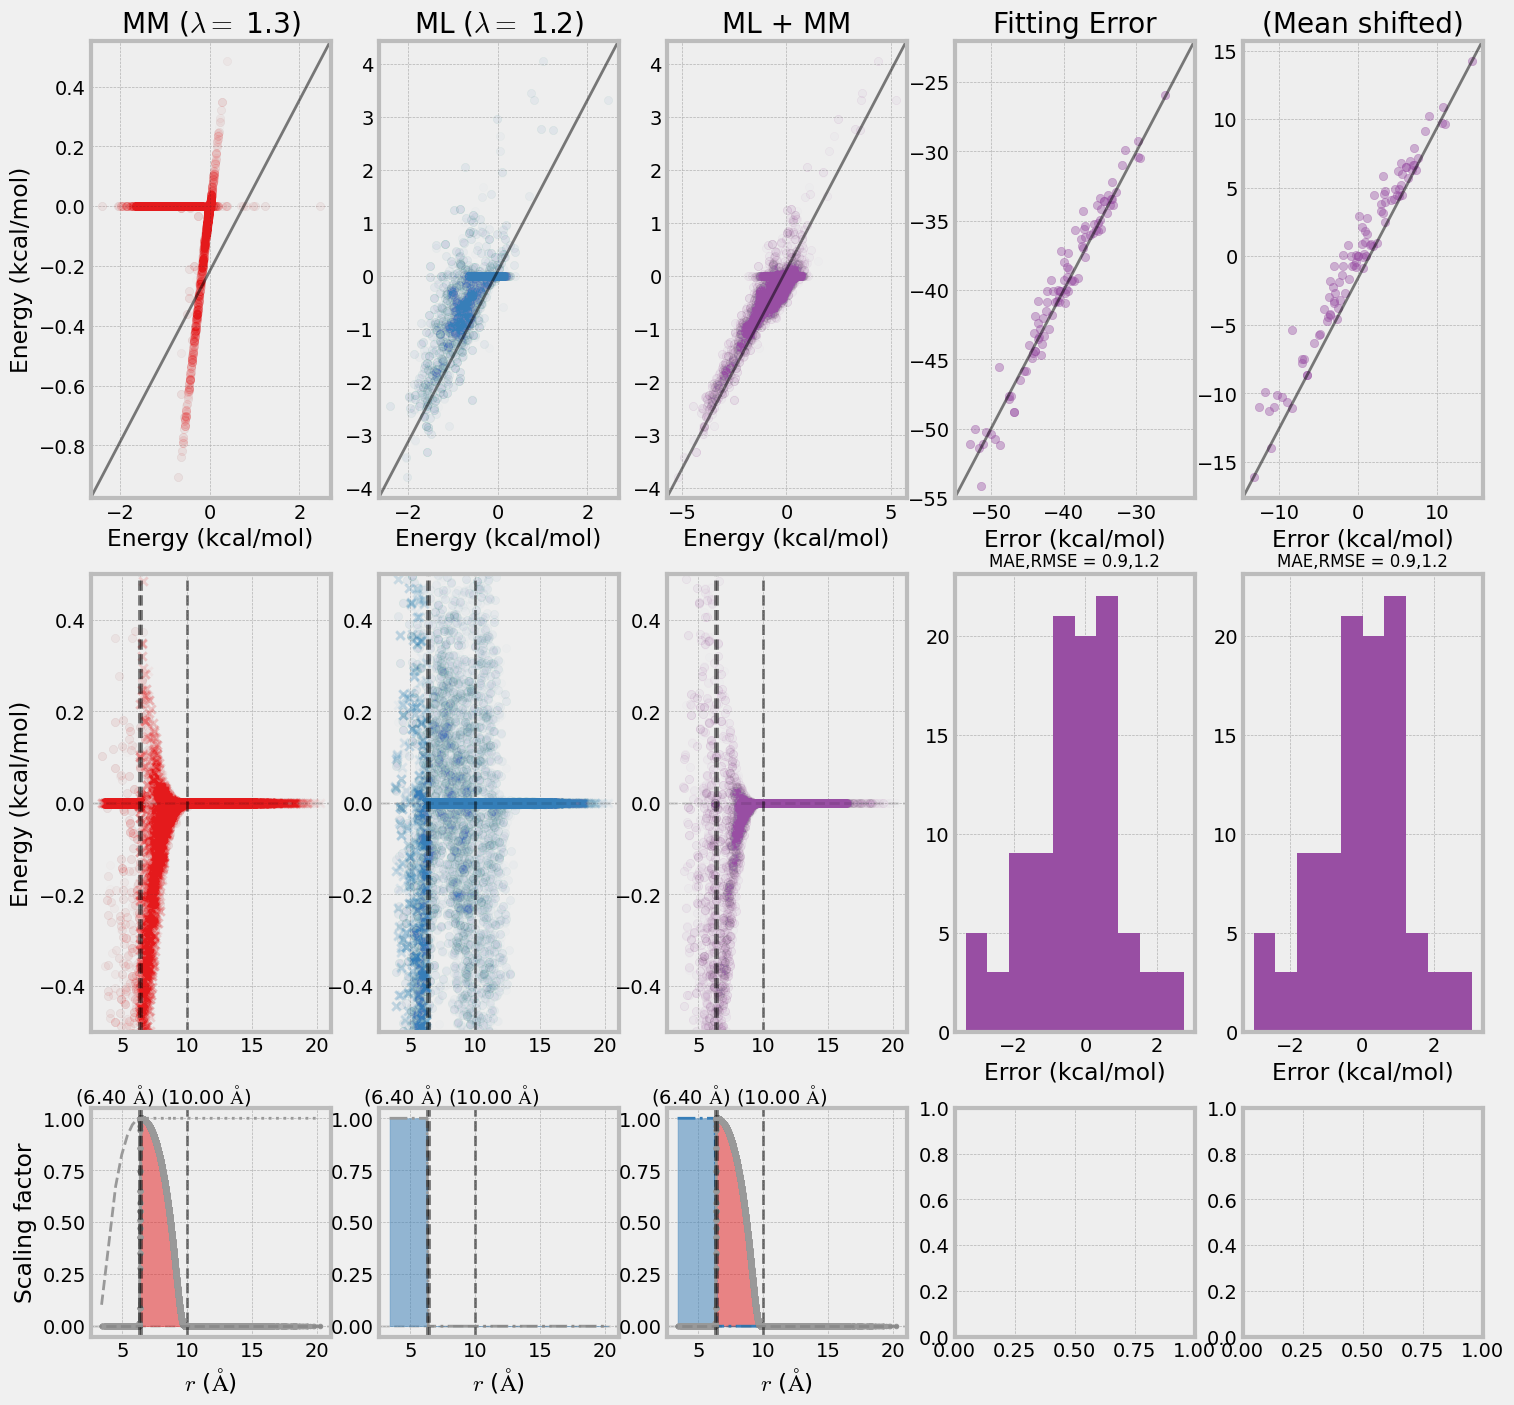

In [1259]:
_ = plot(pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np,
     dif = 10**(-1), 
     MM_CUTON = bestco, 
     MM_CUTOFF = 10, 
     BUFFER = bestbuff,
     MM_E_scale = bests1,
     ML_E_scale = bests2,
     E_SHIFT = 0,
    plot=True,
    )
_

In [1114]:
per_dimer_charmm_energies_np = per_dimer_ele_energies_np + per_dimer_evdw_energies_np

jnp.array(per_dimer_charmm_energies_np)

Array[100, 190] n=19000 (74Kb) x∈[-2.420, 2.456] μ=-0.240 σ=0.431 gpu:0

In [1140]:
# plt.hist(jnp.array(qm_E), bins=12)

In [1074]:
jnp.array(per_dimer_charmm_energies_np).reshape(100, 190).sum(axis=1)

Array[100] x∈[-56.722, -35.306] μ=-45.621 σ=4.704 gpu:0

In [1075]:
len(np.arange(1.2, 2.3, 0.1)), len(np.arange(5, 8, 0.2))

(11, 15)

In [1076]:
11*11*5*15

9075

In [8]:
dimers_data = np.load(Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz"), allow_pickle=True)

In [9]:
list(dimers_data.keys())

['N', 'E', 'Q', 'D', 'Z', 'R', 'F', 'keys']

In [59]:
from scipy.spatial.distance import pdist, squareform
import jax.numpy as jnp
# def validate_data():
keys = dimers_data["keys"]
N = dimers_data["N"]
R = dimers_data["R"]

monomer_ids = np.where(5.0 == N)
print(N[monomer_ids])
print(len(monomer_ids[0]))
R_monomer = R[monomer_ids]
print(jnp.array(R_monomer))
# return pdist(R_monomer)

R_flat = R.reshape(20999, 10*3)
pairwise =  pdist(R_flat)
# pairwise = validate_data()
pairwise.shape


[5 5 5 ... 5 5 5]
1999
Array[1999, 10, 3] n=59970 (0.2Mb) x∈[-17.787, 17.716] μ=-0.048 σ=6.364 gpu:0


(220468501,)

In [69]:
n = 20999
(n**2 - n)/2

220468501.0

In [ ]:
pairwise

In [64]:
# pairwise.shape
220468501 / 30

7348950.033333333

In [60]:
20999 - len(np.where(pairwise==0.0)[0])

-23061

In [13]:
square_monomer_distance = squareform(pairwise)
np.where(square_monomer_distance[0] == 0.0)

(array([   0, 3587, 4848]),)

In [73]:
np.where(square_monomer_distance[i] == 0.0)

(array([  562, 20778, 20998]),)

In [94]:
leaked_structures_counter = 0
non_leaked_counter = 0
leaked_structures_index = []
nonleaked_structures_index = []
for i in range(20999):
    if len(np.where(square_monomer_distance[i] == 0.0)[0]) > 1:
            leaked_structures_counter += 1
            leaked_structures_index.append(i)
            for _ in np.where(square_monomer_distance[i] == 0.0)[0]:
                leaked_structures_index.append(_)
    else:
        non_leaked_counter += 1
        nonleaked_structures_index.append(i)

In [95]:
20999 - leaked_structures_counter

1514

In [96]:
leaked_structures_counter, non_leaked_counter

(19485, 1514)

In [97]:
4382 + 16617

20999

In [98]:
leaked_n = len(set(range(20999)).difference( set(nonleaked_structures_index) ))
nonleaked_n = len(set(range(20999)).difference( set(leaked_structures_index) ))

In [99]:
leaked_n + nonleaked_n

20999

In [14]:
matches_a, matches_b = np.where(square_monomer_distance == 0.0)

In [15]:
matches_a, matches_b

(array([    0,     0,     0, ..., 20998, 20998, 20998]),
 array([    0,  3587,  4848, ...,   562, 20778, 20998]))

In [18]:
matches_a_keys = keys[matches_a]
matches_b_keys = keys[matches_b]

In [7]:
files = [
    Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz"),

]
NATOMS = 10
train_data, valid_data = prepare_datasets(
    data_key,
    16800,
     4199,
    files,
    clip_esp=False,
    natoms=NATOMS,
    clean=False,
    subtract_atom_energies=False,
    verbose=True,
)

ntest = len(valid_data["E"]) // 2
test_data = {k: v[ntest:] for k, v in valid_data.items()}
valid_data = {k: v[:ntest] for k, v in valid_data.items()}

DEFAULT_DATA_KEYS = ["Z", "R", "D", "E", "F", "N", "keys"]
batch_size = 10

test_batches = prepare_batches(data_key, test_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=DEFAULT_DATA_KEYS)

train_batches = prepare_batches(data_key, train_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=DEFAULT_DATA_KEYS)

valid_batches = prepare_batches(data_key, valid_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=DEFAULT_DATA_KEYS)

                                         dcm_dimers_MP2_20999.npz                                         
┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ N        ┃ E        ┃ Q        ┃ D          ┃ Z           ┃ R              ┃ F              ┃ keys     ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ (20999,) │ (20999,) │ (20999,) │ (20999, 3) │ (20999, 10) │ (20999, 10, 3) │ (20999, 10, 3) │ (20999,) │
└──────────┴──────────┴──────────┴────────────┴─────────────┴────────────────┴────────────────┴──────────┘

dataR (20999, 10, 3)
dataE [-16.64463665 -16.84494252 -16.68936279 -16.69383745 -16.74775377
 -16.79686463 -16.70671807 -16.6819525  -16.70375592 -16.71621446]
dataE [-16.64463665 -16.84494252 -16.68936279 -16.69383745 -16.74775377
 -16.79686463 -16.70671807 -16.6819525  -16.70375592 -16.71621446]
D (20999, 3)
Q 1 (20999,) 20999
Q (20999,)
keys 1 (20999,) 20999
keys (20999,)


In [39]:
test_batch_keys = [test_batches[i]["keys"] for i in range(len(test_batches))]
train_batch_keys = [train_batches[i]["keys"] for i in range(len(train_batches))]
valid_batch_keys = [valid_batches[i]["keys"] for i in range(len(valid_batches))]

In [40]:
test_batch_keys_array = np.concatenate(test_batch_keys).flatten()
train_batch_keys_array = np.concatenate(train_batch_keys).flatten()
valid_batch_keys_array = np.concatenate(valid_batch_keys).flatten()

In [52]:
valid_batch_keys_array.shape, test_batch_keys_array.shape, train_batch_keys_array.shape

((2090,), (2100,), (16800,))

In [41]:
test_leak_counter = 0
valid_leak_counter = 0
compromised_test_structures = []
compromised_valid_structures = []

for (a,b) in zip(matches_a_keys, matches_b_keys):
    if (a in test_batch_keys_array and b in train_batch_keys_array):
        compromised_test_structures.append((a, b))
        test_leak_counter += 1
    if (b in test_batch_keys_array and a in train_batch_keys_array):
        compromised_test_structures.append((b,a))
        test_leak_counter += 1
    if (a in valid_batch_keys_array and b in train_batch_keys_array):
        compromised_valid_structures.append((a, b))
        valid_leak_counter += 1
    if (b in valid_batch_keys_array and a in train_batch_keys_array):
        compromised_valid_structures.append((b,a))
        valid_leak_counter += 1
        

In [54]:
100 - 100*(2100 - len(set([_[0] for _ in compromised_test_structures])))/2100

91.47619047619048

In [103]:
100 - 100*(2090 - len(set([_[0] for _ in compromised_valid_structures])))/2090

90.7177033492823

In [102]:
len(set([_[0] for _ in compromised_test_structures])) + len(set([_[0] for _ in compromised_valid_structures]))

3817

1896

In [44]:
compromised_test_structures

[('100_lig_2/monomers/monomer_14_input.inp.grad_property.txt',
  '100_lig_1/monomers/monomer_16_input.inp.grad_property.txt'),
 ('100_lig_3/monomers/monomer_11_input.inp.grad_property.txt',
  '100_lig_1/monomers/monomer_11_input.inp.grad_property.txt'),
 ('100_lig_4/monomers/monomer_10_input.inp.grad_property.txt',
  '100_lig_1/monomers/monomer_11_input.inp.grad_property.txt'),
 ('100_lig_1/monomers/monomer_15_input.inp.grad_property.txt',
  '100_lig_2/monomers/monomer_13_input.inp.grad_property.txt'),
 ('100_lig_1/monomers/monomer_15_input.inp.grad_property.txt',
  '100_lig_4/monomers/monomer_16_input.inp.grad_property.txt'),
 ('100_lig_1/monomers/monomer_15_input.inp.grad_property.txt',
  '100_lig_5/monomers/monomer_16_input.inp.grad_property.txt'),
 ('100_lig_35/monomers/monomer_10_input.inp.grad_property.txt',
  '100_lig_1/monomers/monomer_6_input.inp.grad_property.txt'),
 ('100_lig_4/monomers/monomer_8_input.inp.grad_property.txt',
  '100_lig_1/monomers/monomer_9_input.inp.grad_pr

In [1314]:
R_monomer_stacked = R_monomer.reshape(1999 * 10, 3)

In [1315]:
ssx = np.array([ 5*i for i in range(1999)]).flatten()
ssx

array([   0,    5,   10, ..., 9980, 9985, 9990])

In [1317]:
mol1, mol2 = R_monomer_stacked[ssx[0]:ssx[0]+5], R_monomer_stacked[ssx[0]:ssx[0]+5]

In [1320]:
# pdist()
np.array([mol1, mol2])

array([[[-2.759,  0.275,  3.674],
        [-3.243,  1.259,  3.754],
        [-2.485, -0.127,  4.689],
        [-1.191,  0.139,  2.853],
        [-3.88 , -0.934,  3.111]],

       [[-2.759,  0.275,  3.674],
        [-3.243,  1.259,  3.754],
        [-2.485, -0.127,  4.689],
        [-1.191,  0.139,  2.853],
        [-3.88 , -0.934,  3.111]]])

In [1339]:
def get_fast_dist_matrix(xyz, ssx, molecule_id):
    start_molecule, end_molecule = ssx[molecule_id], ssx[molecule_id+1]
    locs = xyz[start_molecule:end_molecule]    
    num_atoms = end_molecule - start_molecule
    loc_tile = np.tile(locs.T, (num_atoms,1,1))
    dist_mat = np.sqrt((loc_tile - loc_tile.T)**2).sum(axis=1)
    if np.sum(dist_mat) == 0:
        print(ssx[molecule_id]/5, ssx[molecule_id+1]/5, loc_tile)
    return dist_mat

get_fast_dist_matrix(R_monomer_stacked, ssx, 0)

array([[0.   , 1.548, 1.691, 2.525, 2.893],
       [1.548, 0.   , 3.079, 4.073, 3.473],
       [1.691, 3.079, 0.   , 3.396, 3.78 ],
       [2.525, 4.073, 3.396, 0.   , 4.02 ],
       [2.893, 3.473, 3.78 , 4.02 , 0.   ]])

In [1342]:
def get_fast_dist_matrix(m1, m2):
    dist_mat = np.sqrt((m1, m2)**2).sum(axis=1)
    if np.sum(dist_mat) == 0:
        print(m1, m2)
    return dist_mat

In [1340]:
R_monomer[1], R_monomer[2]

In [1347]:
# for i in range(1999):
#     for j in range(1999):
#         if i < j:
            

In [1341]:
dms = []
distances = []
from tqdm import tqdm
for molecule_id in tqdm(range(1999 - 1)):
    dm = get_fast_dist_matrix(R_monomer_stacked, ssx, molecule_id)
    print(molecule_id, molecule_id+1, np.sum(dm), dm.shape)
    dms.append(dm)

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 1004/1998 [00:00<00:00, 3348.21it/s]

0 1 60.955999999999996 (5, 5)
1.0 2.0 [[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
1 2 0.0 (5, 5)
2 3 60.711999999999996 (5, 5)
3.0 4.0 [[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
3 4 0.0 (5, 5)
4 5 59.6 (5, 5)
5.0 6.0 [[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:00<00:00, 3349.36it/s]

1004 1005 59.847999999999985 (5, 5)
1005.0 1006.0 [[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
1005 1006 0.0 (5, 5)
1006 1007 59.403999999999996 (5, 5)
1007.0 1008.0 [[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
1007 1008 0.0 (5, 5)
1008 1009 59.41999999999999 (5, 5)
1009.0 1010.0 [[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0

In [1332]:
dms

[array([[0.   , 1.548, 1.691, 2.525, 2.893],
        [1.548, 0.   , 3.079, 4.073, 3.473],
        [1.691, 3.079, 0.   , 3.396, 3.78 ],
        [2.525, 4.073, 3.396, 0.   , 4.02 ],
        [2.893, 3.473, 3.78 , 4.02 , 0.   ]]),
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([[0.   , 1.732, 1.792, 2.561, 2.686],
        [1.732, 0.   , 2.954, 3.847, 2.958],
        [1.792, 2.954, 0.   , 3.067, 3.672],
        [2.561, 3.847, 3.067, 0.   , 5.087],
        [2.686, 2.958, 3.672, 5.087, 0.   ]]),
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([[0.   , 1.246, 1.649, 3.048, 2.559],
        [1.246, 0.   , 2.895, 4.18 , 3.509],
        [1.649, 2.895, 0.   , 3.443, 3.398],
        [3.048, 4.18 , 3.443, 0.   , 3.873],
        [2.559, 3.509, 3.398, 3.873, 0.   ]]),
 array([[0., 0.

In [1302]:
R_monomer[:2].shape

(2, 10, 3)

In [1304]:
# pdist(R_monomer[:2])

from jax import jit
from math import sqrt

@jit
def numba_dist_matrix(xyz, ssx, molecule_id):
    start_molecule, end_molecule = ssx[molecule_id], ssx[molecule_id+1]
    locs = xyz[start_molecule:end_molecule]     
   # return locs
    num_atoms = end_molecule - start_molecule
    dmat = np.zeros((num_atoms, num_atoms))
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            d = sqrt((locs[i,0] - locs[j,0])**2 + (locs[i,1] - locs[j,1])**2 + (locs[i,2] - locs[j,2])**2)
            dmat[i,j] = d
            dmat[j,i] = d
    return dmat

def numba_dist_matrices(xyz, ssx):
    for molecule_id in range(structures.molecule_name.nunique()):
        numba_dist_matrix(xyz, ssx, molecule_id)


In [ ]:
# pairwise_dist = np.zeros(1999, 1999)

# for i in range(1999):
#     for j in range(1999):
#         if i < j:
#             pairwise_dist[i][j] = 

44060

(array([ 20683., 183853., 321979., 429358., 450014., 346349., 178482.,
         57675.,   8136.,    472.]),
 array([  0.        ,  11.112294  ,  22.224588  ,  33.336882  ,
         44.449176  ,  55.56147   ,  66.673764  ,  77.786058  ,
         88.898352  , 100.01064599, 111.12293999]),
 <BarContainer object of 10 artists>)

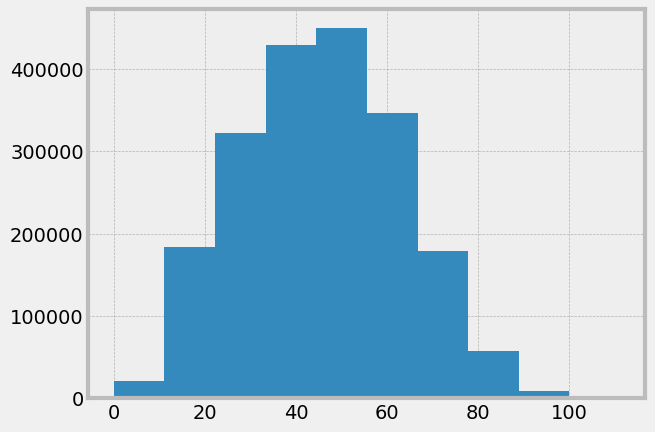

In [1299]:
plt.hist(pairwise)

In [1298]:
square_monomer_distance.shape

(1999, 1999)

In [115]:
in_out = (square_monomer_distance != 0.0) * np.ones_like(square_monomer_distance)  

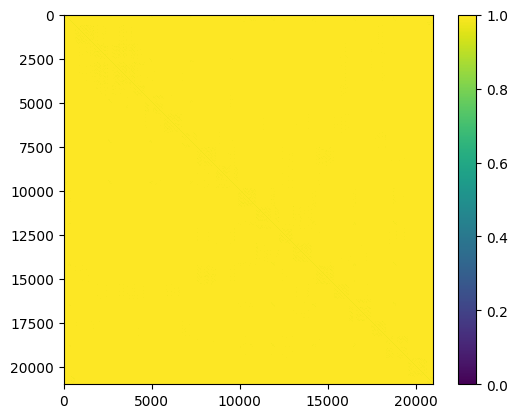

In [116]:
import matplotlib.pyplot as plt
plt.imshow(in_out  )
plt.colorbar()

In [117]:
in_out

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [1248]:
dimers_data["N"][-1]

10

In [1077]:
len(np.arange(1.3, 2.0, 0.01))

len(np.arange(1.95, 2.1, 0.001))**2

22801

In [1078]:
# scales = [0.1, 0.3, 0.6, 0.9, 1, 1.1, 1.4, 1.7, 1.9]
scales = scales1 = scales2 = np.arange(1.2, 2.3, 0.1) #[ 0.9, 1, 1.1, 1.4, 1.5, 1.7,  2.0, ]
# scales1 = np.arange(1.45, 2.1, 0.01)
# scales2 = np.arange(1.45, 2.1, 0.01)
# scales1 = np.arange(1.95, 2.1, 0.001)
# scales2 = np.arange(1.45, 1.55, 0.001)
buffers = [0.001, 0.1, 0.5, 0.9, 1, 2,]
best = 10000

for buff in buffers:
    for CO in np.arange(5, 8, 0.2):
        for s1 in scales1:
            for s2 in scales2:
                _ =plot(pair_cc_distances_per_dimer_np,
                    per_dimer_charmm_energies_np, 
                    per_dimer_ml_energies_np,
                     dif = 10**(-1), 
                     MM_CUTON = CO, 
                     MM_CUTOFF = 14, 
                     BUFFER = buff,
                     MM_E_scale = s1,
                     ML_E_scale = s2,
                     E_SHIFT = 0,
                      # plot=True,
                    )
                if _ < best:
                    best = _
                    print(s1, s2, CO, buff, _)
                    bests1 = s1
                    bests2 = s2
                    bestco = CO
                    bestbuff = buff

print("Done")
print("bests1", bests1)
print("bests2", bests2)
print("bestco", bestco)
print("bestbuff", bestbuff)

1.2 1.2 5.0 0.001 Array gpu:0 12.047
1.2 1.2 5.2 0.001 Array gpu:0 10.067
1.2 1.2 5.4 0.001 Array gpu:0 8.231
1.2 1.2 5.6000000000000005 0.001 Array gpu:0 6.543
1.2 1.2 5.800000000000001 0.001 Array gpu:0 3.982
1.2 1.2 6.000000000000001 0.001 Array gpu:0 2.783
1.2 1.2 6.200000000000001 0.001 Array gpu:0 1.634
1.2 1.2 6.400000000000001 0.001 Array gpu:0 1.252
1.3 1.2 6.400000000000001 0.001 Array gpu:0 1.205
Done
bests1 1.3
bests2 1.2
bestco 6.400000000000001
bestbuff 0.001


Array gpu:0 1.203

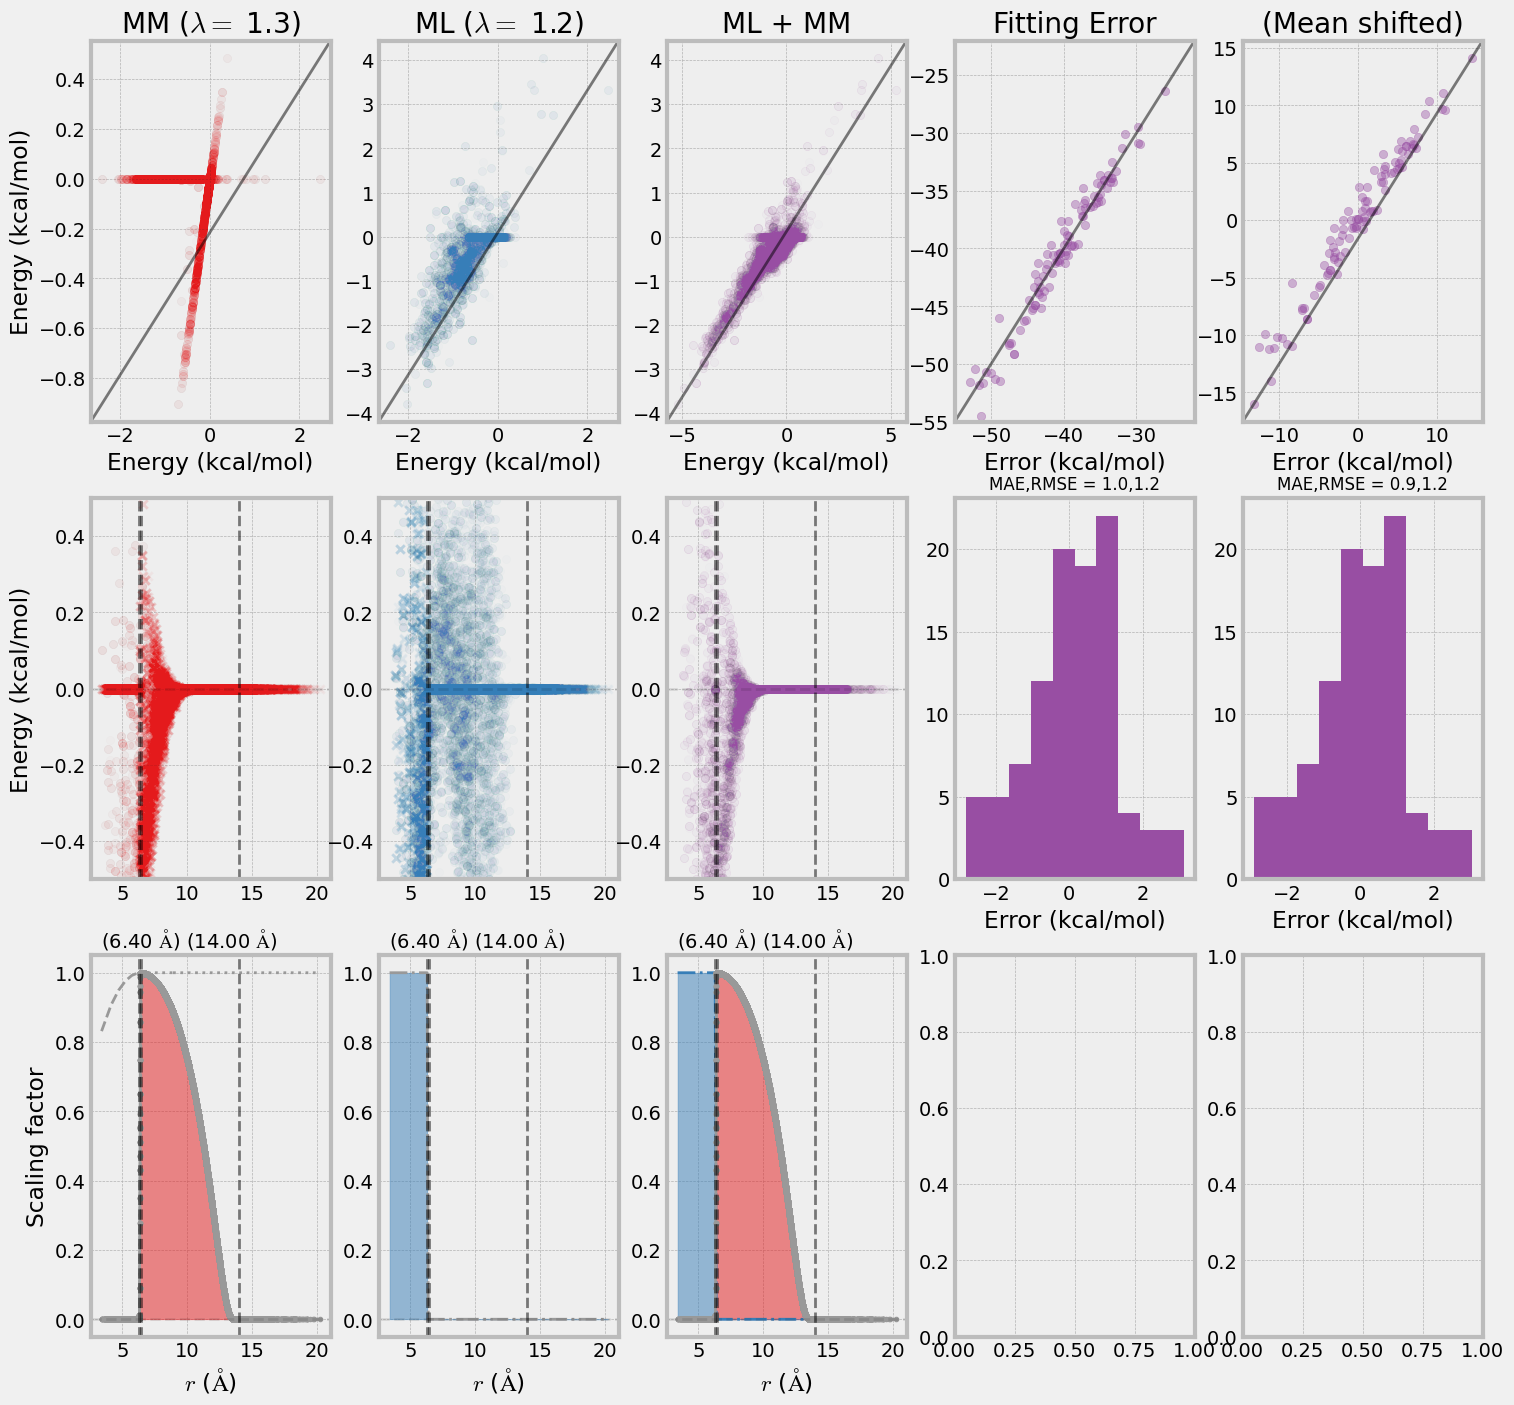

In [1232]:
# 1.9 1.4
_ = plot(pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np,
     dif = 10**(-1), 
     MM_CUTON = bestco, 
     MM_CUTOFF = 14, 
     BUFFER = bestbuff,
     MM_E_scale = bests1,
     ML_E_scale = bests2,
     E_SHIFT = 0,
    plot=True,
    )
_

Array gpu:0 1.626

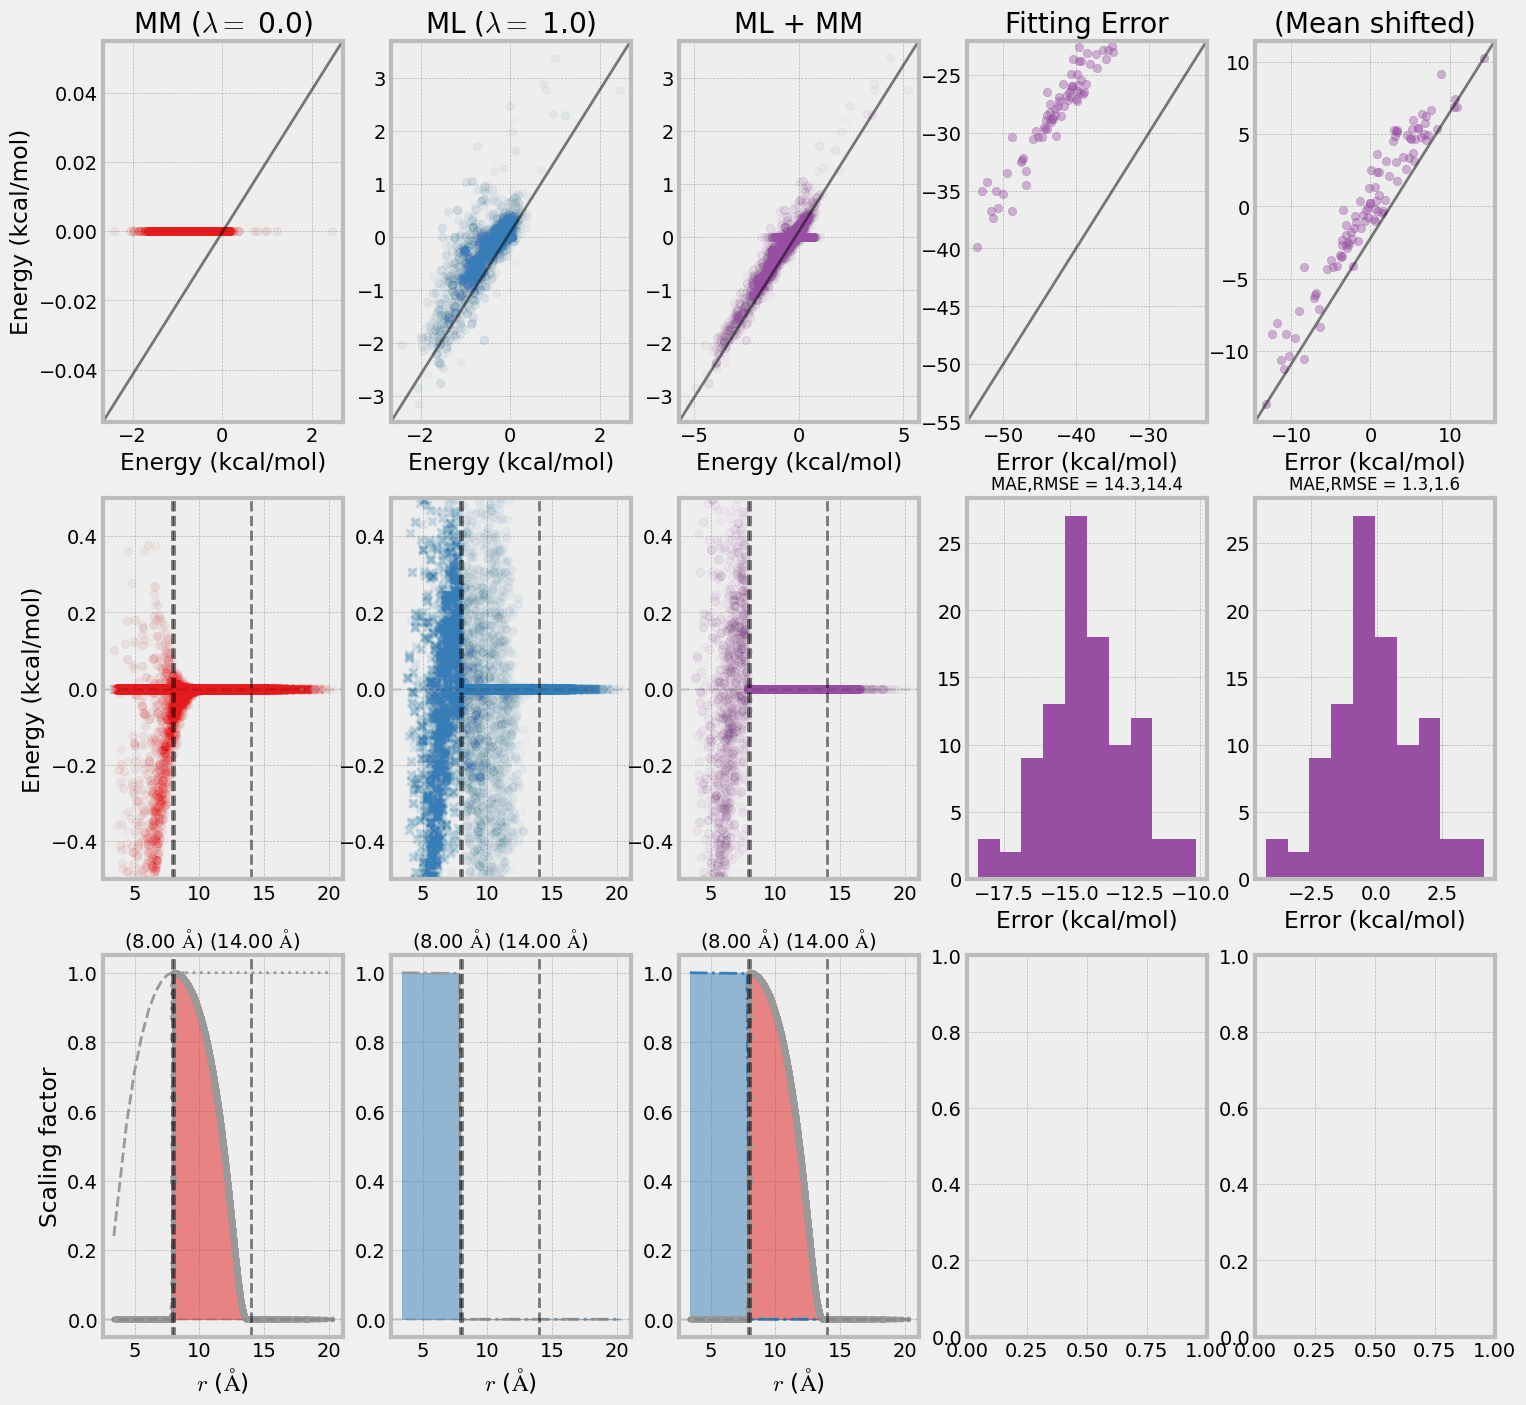

In [1233]:

_ = plot(pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np,
     dif = 10**(-1), 
     MM_CUTON = 8.0, 
     MM_CUTOFF = 14, 
     BUFFER = 0.1,
     MM_E_scale = 0,
     ML_E_scale = 1,
     E_SHIFT = 0,
     plot=True,
    )
_

Array gpu:0 2.981

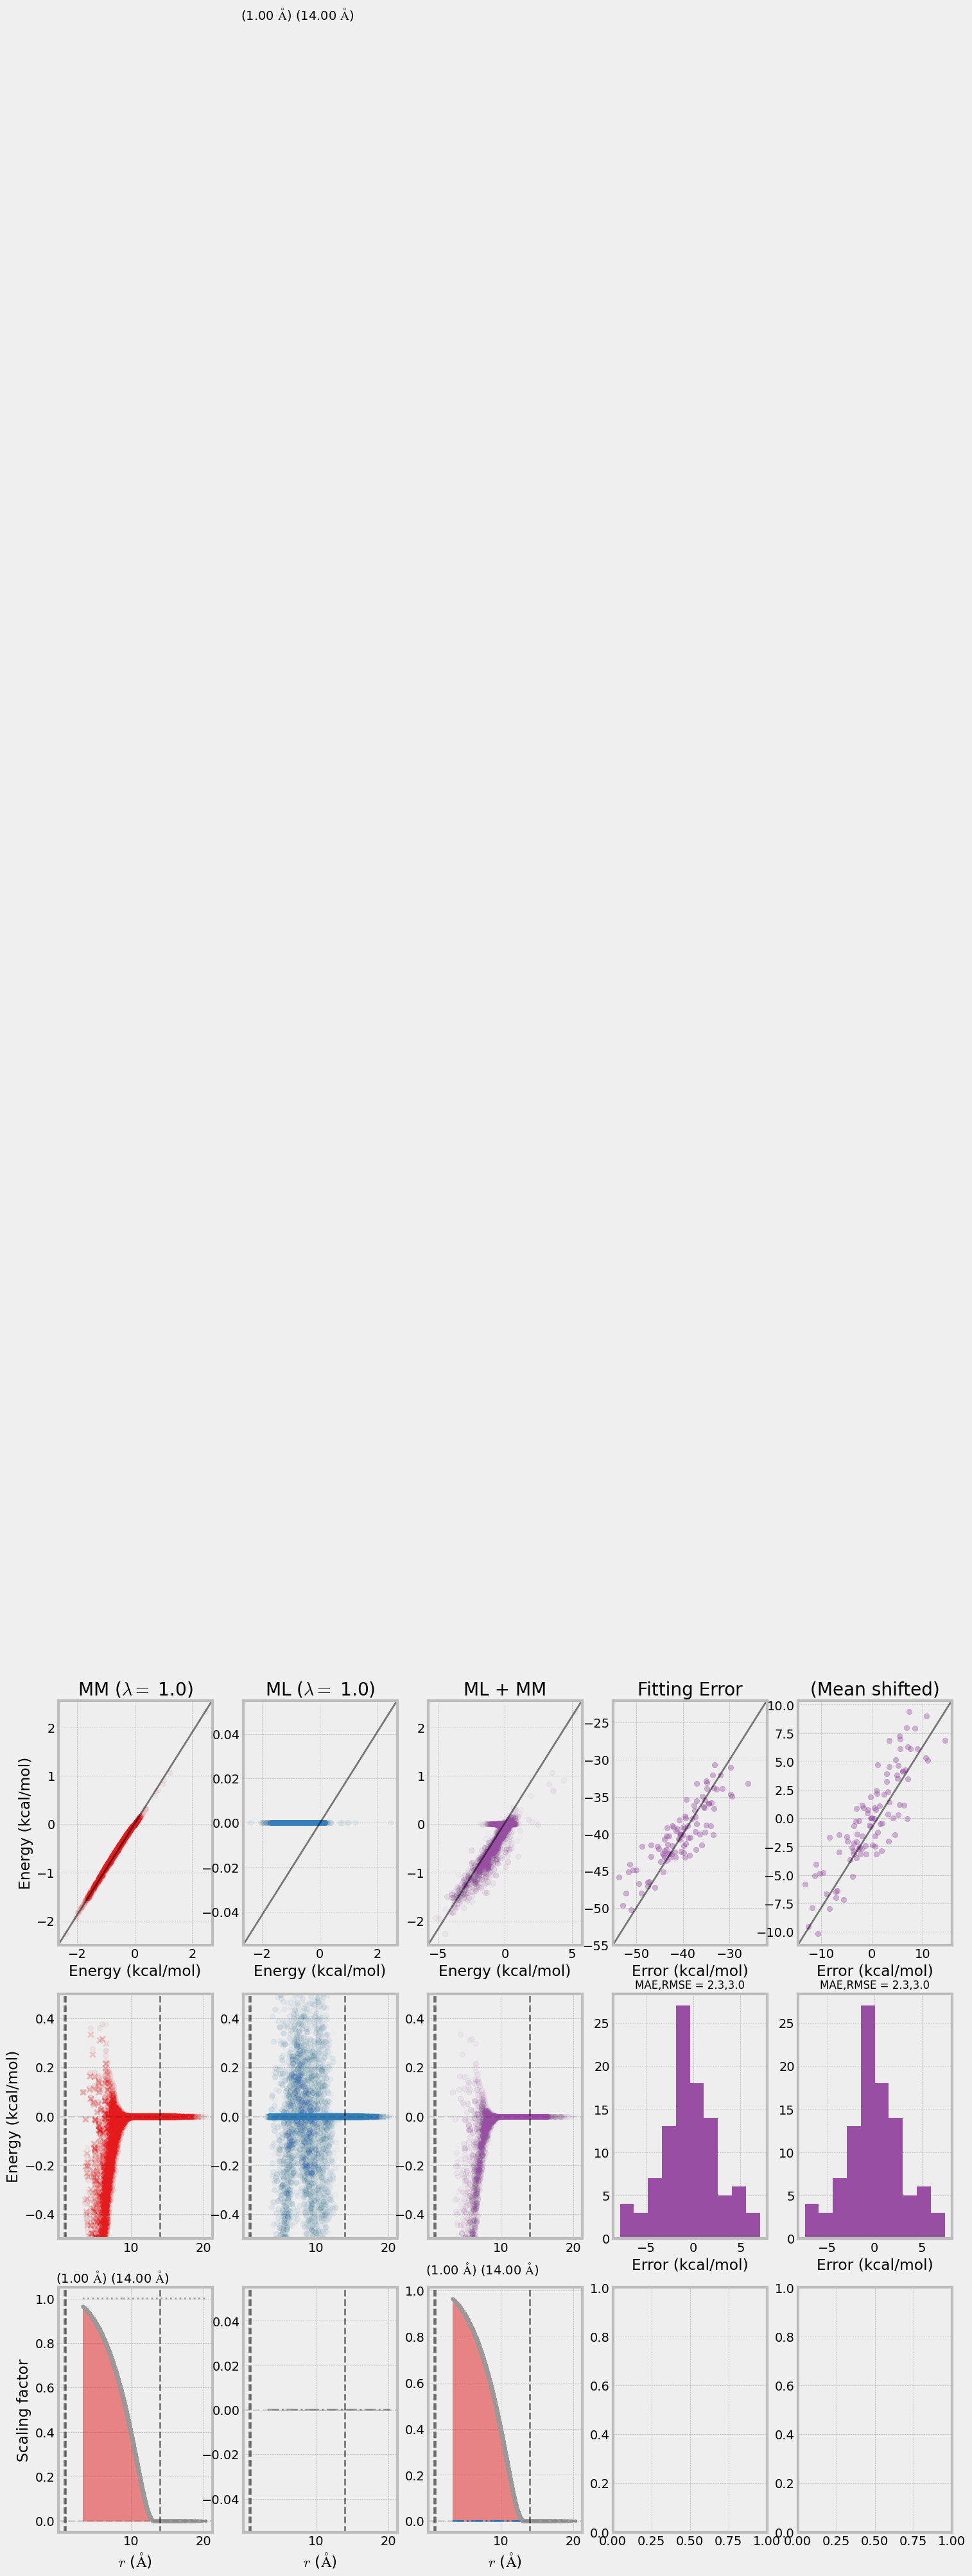

In [1237]:

_ = plot(pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np,
     dif = 10**(-1), 
     MM_CUTON = 1.0, 
     MM_CUTOFF = 14, 
     BUFFER = 0.1,
     MM_E_scale = 1,
     ML_E_scale = 1,
     E_SHIFT = 0,
               plot=True,
    )
_

Array gpu:0 4.520

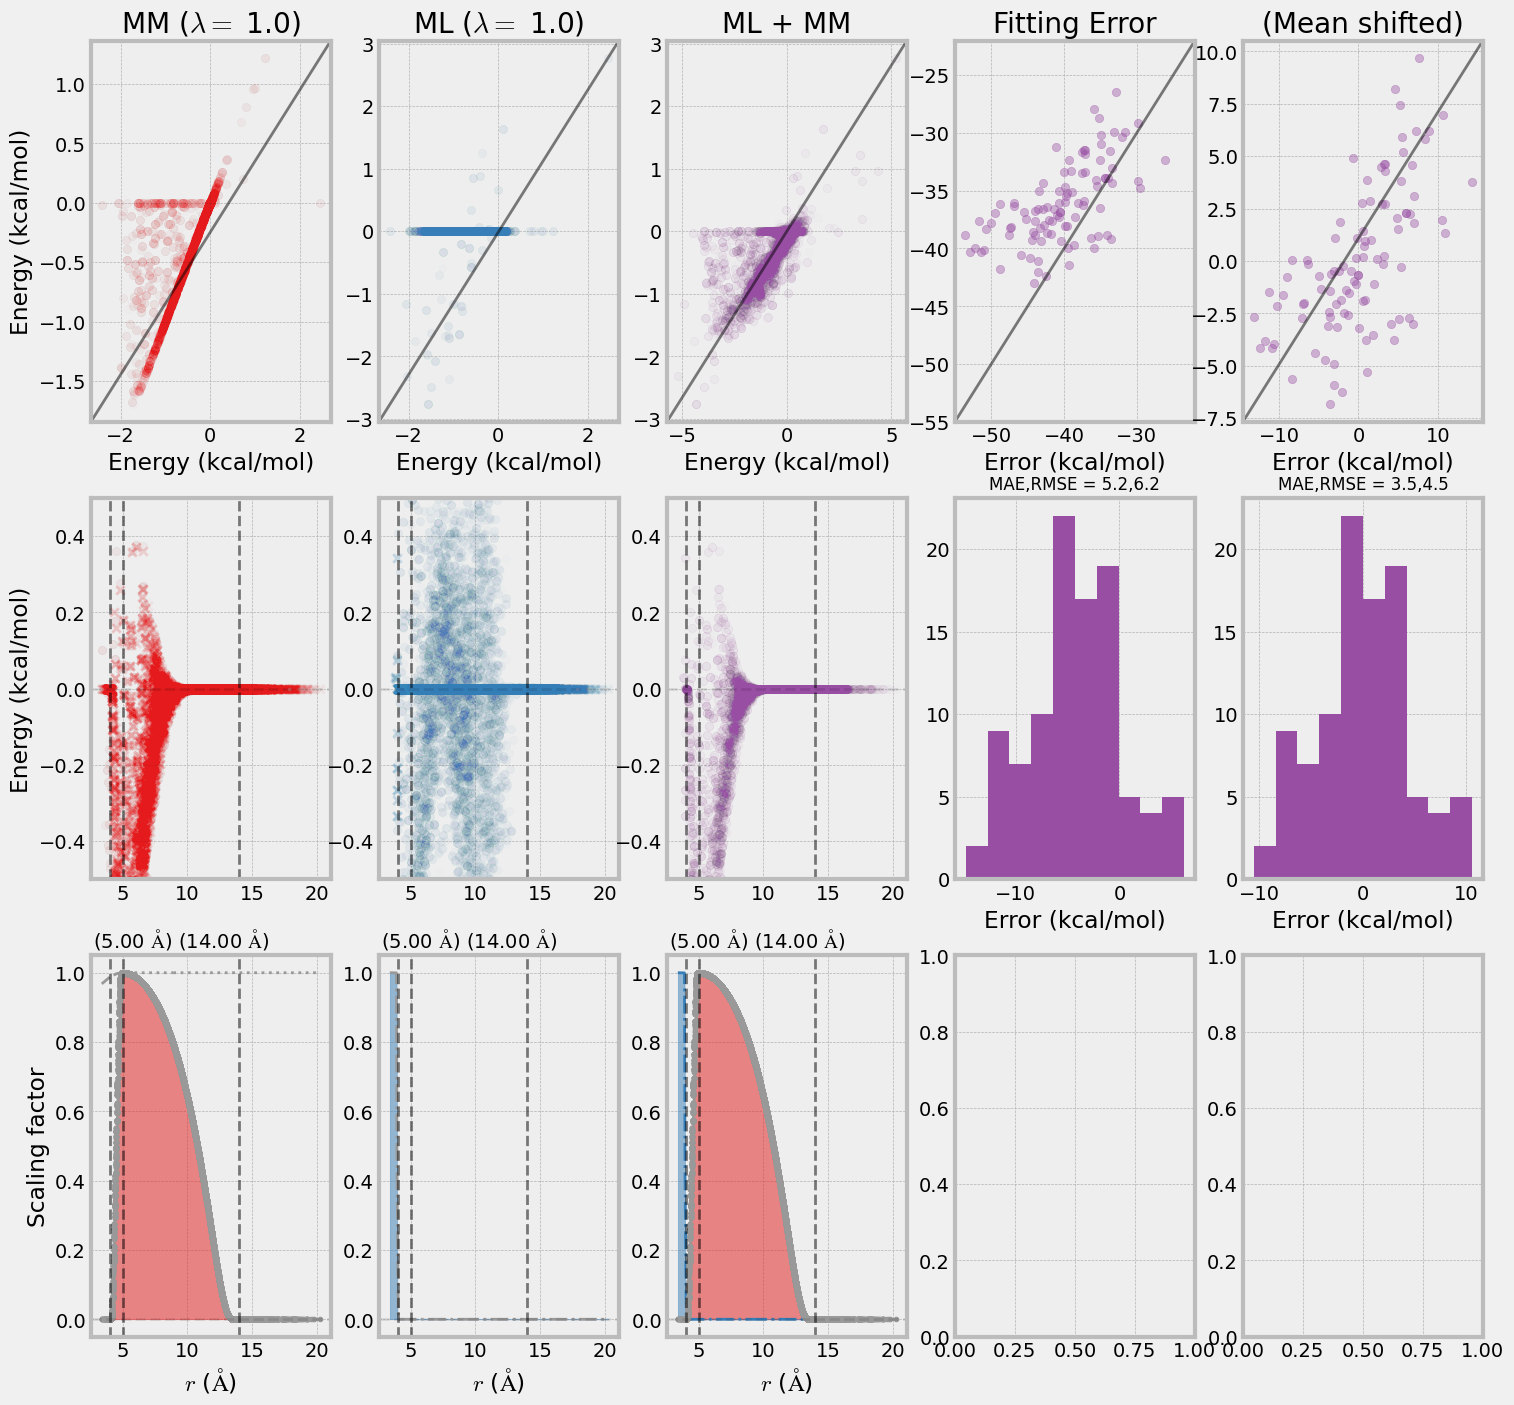

In [1235]:
_ = plot(pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np,
     dif = 1, 
     MM_CUTON = 5.0, 
     MM_CUTOFF = 14, 
     BUFFER = 0.1,
     MM_E_scale=1,
     ML_E_scale = 1,
     E_SHIFT = 1,
      plot=True,
    )
_